In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
#libraries for 3D plotting
from mpl_toolkits import mplot3d
from matplotlib import cm

In [4]:
#function of 3D plot
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot
    of the scalar field p.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction;
        default: 'z'.
    elev : float, optional
        Elevation angle in the z plane;
        default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane;
        default: 45.0.
    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    fig.add_axes(ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

In [5]:
def laplace_solution(x, y, Lx, Ly):
    """
    Computes and returns the analytical solution of the Laplace equation
    on a given two-dimensional Cartesian grid.

    Parameters
    ----------
    x : numpy.ndarray
        The gridline locations in the x direction
        as a 1D array of floats.
    y : numpy.ndarray
        The gridline locations in the y direction
        as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats.
    """
    X, Y = numpy.meshgrid(x, y) #meshgrid allows to plot on the whole 2D space
    p = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    return p

c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


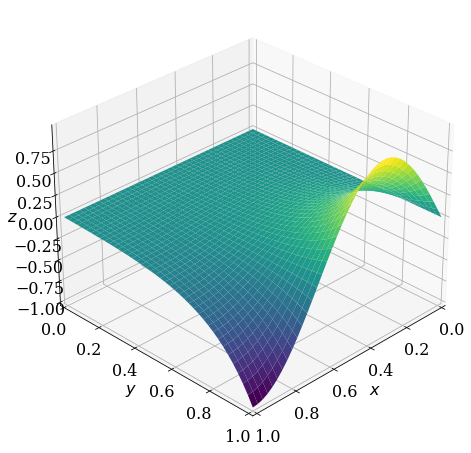

In [6]:
# Set parameters.
Lx = 1.0  # domain length in the x direction
Ly = 1.0  # domain length in the y direction
nx = 41  # number of points in the x direction
ny = 41  # number of points in the y direction

# Create the gridline locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the analytical solution.
p_exact = laplace_solution(x, y, Lx, Ly)

# Plot the analytical solution.
plot_3d(x, y, p_exact)

To compare two successive potential fields ($\mathbf{p}^k$ and $\mathbf{p}^{k+1}$), a good option is to use the [L2 norm](http://en.wikipedia.org/wiki/Norm_%28mathematics%29#Euclidean_norm) of the difference.  It's defined as

$$
\begin{equation}
    \parallel \mathbf{p}^{k+1} - \mathbf{p}^k \parallel_{L_2} = \sqrt{\sum_{i, j} \left| p_{i, j}^{k+1} - p_{i, j}^k \right|^2}
\end{equation}
$$

But there's one flaw with this formula.  We are summing the difference between successive iterations at each point on the grid. *So what happens when the grid grows? (For example, if we're refining the grid, for whatever reason.) There will be more grid points to compare and so more contributions to the sum. The norm will be a larger number just because of the grid size!*

That doesn't seem right.  We'll fix it by normalizing the norm, dividing the above formula by the norm of the potential field at iteration $k$. 

For two successive iterations, the relative L2 norm is then calculated as

$$
\begin{equation}
    \frac{\parallel \mathbf{p}^{k+1} - \mathbf{p}^k \parallel_{L_2}}{\parallel \mathbf{p}^k \parallel_{L_2}} = \frac{\sqrt{\sum_{i, j} \left| p_{i, j}^{k+1} - p_{i, j}^k \right|^2}}{\sqrt{\sum_{i, j} \left| p_{i, j}^k \right|^2}}
\end{equation}
$$

For this purpose, we define the `l2_norm` function:

In [7]:
def l2_norm(p, p_ref):
    """
    Computes and returns the relative L2-norm of the difference
    between a solution p and a reference solution p_ref.

    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats.
    p_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The relative L2-norm of the difference.
    """
    l2_diff = (numpy.sqrt(numpy.sum((p - p_ref)**2)) /
               numpy.sqrt(numpy.sum(p_ref**2)))
    return l2_diff

In [8]:
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    
    p = p0.copy()
    diff = rtol + 1.0 #inital diff: can be any value greater than rtol to initiate the while loop
    sol = [p0.copy()]
    ite = 0 #initialize ite counter
    while diff>rtol and ite<maxiter:
        pn = p.copy()
        p[1:-1, 1:-1] = 0.25 * (p[1:-1, :-2] + p[1:-1, 2:] +
                                p[:-2, 1:-1] + p[2:, 1:-1])
        #Neumann bc (1st order discretization of bc) at right bc
        p[1:-1, -1] = p[1:-1, -2]
        #store soln at each iteration
        sol.append(p)
        #Compute the residual as L2-norm of the diff.
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff, sol

In [9]:
#Setting initial conditions
p0 = numpy.zeros((ny, nx))
#the initial guess is 0 at all locations, except top boundary with foll. dirichlet bc
p0[-1, :] = numpy.sin(1.5*numpy.pi*x / Lx)

c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


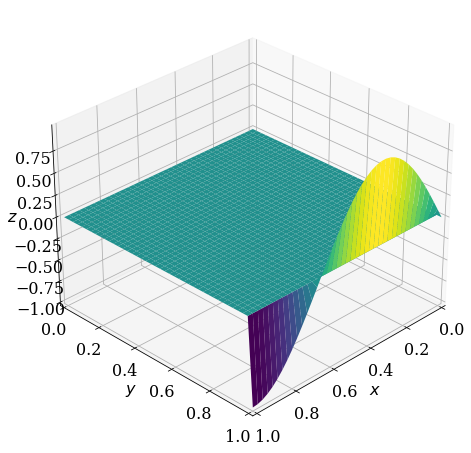

In [10]:
#plot initial guess
plot_3d(x, y, p0)

In [11]:
#Compute final soln
p, ites, diff, sol1 = laplace_2d_jacobi(p0, rtol = 1e-6)
print('Jacobi relaxation: {} iterations '.format(ites) + 
     'to reach a relative diff of {}'.format(diff))

Jacobi relaxation: 2097 iterations to reach a relative diff of 9.985166263344611e-07


c:\users\narkh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


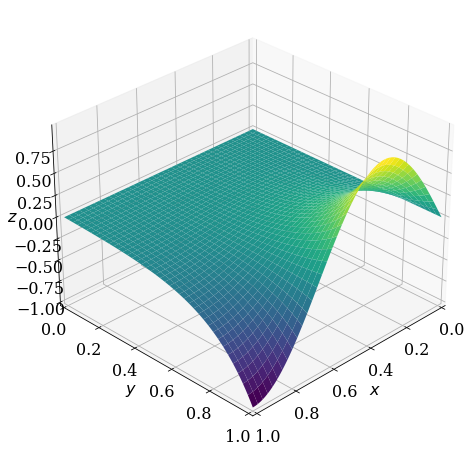

In [20]:
plot_3d(x, y, p)

## Convergence Analysis

Here only spatial analysis will be conducted as there is no time dependency. Remeber, the solution to the Poisson's equation, and its cases, like the Laplace's equation is highly driven by the boundary conditions.

Spatial analysis: Check the convergence by refining the mesh/grid

In [15]:
# List of the grid sizes to investigate.
nx_values = [11, 21, 41, 81]

# Create an empty list to record the error on each grid.
errors = []

# Compute the solution and error for each grid size.
for nx in nx_values:
    ny = nx  # same number of points in all directions.
    # Create the gridline locations.
    x = numpy.linspace(0.0, Lx, num=nx)
    y = numpy.linspace(0.0, Ly, num=ny)
    # Set the initial conditions.
    p0 = numpy.zeros((ny, nx))
    p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    # Relax the solution.
    # We do not return the number of iterations or
    # the final relative L2-norm of the difference.
    p, _, _, _ = laplace_2d_jacobi(p0, rtol=1e-8)
    # Compute the analytical solution.
    p_exact = laplace_solution(x, y, Lx, Ly)
    # Compute and record the relative L2-norm of the error.
    errors.append(l2_norm(p, p_exact))

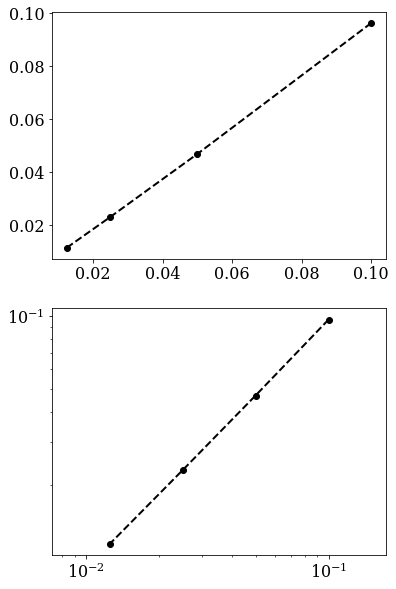

In [16]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 10.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid()
dx_values = Lx / (numpy.array(nx_values) - 1)
pyplot.subplot(2,1,1)
pyplot.plot(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.subplot(2,1,2)
pyplot.loglog(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');

Even though we used 2nd order discretization for our problem, the convergence doesn't look 2nd order. It almost looks similar to 1st order. (revise last two notebooks of Phugoid Model i.e. Module 1)

To solve this issue, we need to treat the Neumann bc with 2nd order discretization. 

Up to this point, we have used the first-order approximation of a derivative to satisfy Neumann B.C.'s. For a boundary located at $x=0$ this reads,

$$
\begin{equation}
\frac{p^{k+1}_{1,j} - p^{k+1}_{0,j}}{\Delta x} = 0
\end{equation}
$$

which, solving for $p^{k+1}_{0,j}$ gives us

$$
\begin{equation}
p^{k+1}_{0,j} = p^{k+1}_{1,j}
\end{equation}
$$

Using that Neumann condition will limit us to 1st-order convergence.  Instead, we can start with a 2nd-order approximation (the central-difference approximation):

$$
\begin{equation}
\frac{p^{k+1}_{1,j} - p^{k+1}_{-1,j}}{2 \Delta x} = 0
\end{equation}
$$

That seems problematic, since there is no grid point $p^{k}_{-1,j}$.  But no matter … let's carry on. According to the 2nd-order approximation,

$$
\begin{equation}
p^{k+1}_{-1,j} = p^{k+1}_{1,j}
\end{equation}
$$

Recall the finite-difference Jacobi equation with $i=0$:

$$
\begin{equation}
p^{k+1}_{0,j} = \frac{1}{4} \left(p^{k}_{0,j-1} + p^k_{0,j+1} + p^{k}_{-1,j} + p^k_{1,j} \right)
\end{equation}
$$

Notice that the equation relies on the troublesome (nonexistent) point $p^k_{-1,j}$, but according to the equality just above, we have a value we can substitute, namely $p^k_{1,j}$. Ah! We've completed the 2nd-order Neumann condition:

$$
\begin{equation}
p^{k+1}_{0,j} = \frac{1}{4} \left(p^{k}_{0,j-1} + p^k_{0,j+1} + 2p^{k}_{1,j} \right)
\end{equation}
$$

That's a bit more complicated than the first-order version, but it's relatively straightforward to code.

Now we create a similar laplace_2d_jacobi function with the 2nd order discretized Neumann boundary condition and see its convergence. 

In [17]:
def laplace_2d_jacobi_neumann(p0, maxiter=20000, rtol=1e-6):
    p = p0.copy()
    diff = rtol + 1.0  # intial difference
    ite = 0  # iteration index
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        # Update the solution at interior points.
        p[1:-1, 1:-1] = 0.25 * (p[1:-1, :-2] + p[1:-1, 2:] +
                                p[:-2, 1:-1] + p[2:, 1:-1])
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] +
                              pn[2:, -1] + pn[:-2, -1])
        # Compute the residual as the L2-norm of the difference.
        diff = l2_norm(p, pn)
        ite += 1
    return p, ite, diff

In [18]:
# List of the grid sizes to investigate.
nx_values = [11, 21, 41, 81]

# Create an empty list to record the error on each grid.
errors = []

# Compute the solution and error for each grid size.
for nx in nx_values:
    ny = nx  # same number of points in all directions.
    # Create the gridline locations.
    x = numpy.linspace(0.0, Lx, num=nx)
    y = numpy.linspace(0.0, Ly, num=ny)
    # Set the initial conditions.
    p0 = numpy.zeros((ny, nx))
    p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)
    # Relax the solution.
    # We do not return the number of iterations or
    # the final relative L2-norm of the difference.
    p, _, _ = laplace_2d_jacobi_neumann(p0, rtol=1e-8)
    # Compute the analytical solution.
    p_exact = laplace_solution(x, y, Lx, Ly)
    # Compute and record the relative L2-norm of the error.
    errors.append(l2_norm(p, p_exact))

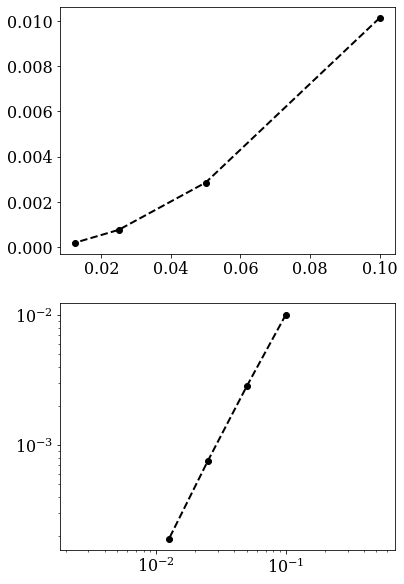

In [19]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 10.0))
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.grid()
dx_values = Lx / (numpy.array(nx_values) - 1)
pyplot.subplot(2,1,1)
pyplot.plot(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.subplot(2,1,2)
pyplot.loglog(dx_values, errors, color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');

Now that looks like a 2nd order convergence. As the grid is refined by the factor of half, the error is reduced by 4 time. Thus the ${\mathcal O}(\Delta x^2)$, second order discretization is followed